In [2]:
# Import satements
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

## Set Up Environment

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ❌ DO NOT RUN THIS CELL ❌
# Installing Kaggle
!pip install kaggle

In [ ]:
# ❌ DO NOT RUN THIS CELL ❌
# Uploading Kaggle API Key to Google Colab
from google.colab import files
upload = files.upload()

Saving kaggle.json to kaggle.json


## Data Accquisition

In [ ]:
# ❌ DO NOT RUN THIS CELL ❌
!kaggle datasets download -d asdasdasasdas/garbage-classification

 84% 69.0M/82.0M [00:01<00:00, 58.2MB/s]
100% 82.0M/82.0M [00:01<00:00, 74.3MB/s]


In [ ]:
# ❌ DO NOT RUN THIS CELL ❌
# unzip dataset

!unzip -o /content/garbage-classification.zip -d /content/drive/MyDrive/3B/ECE342/project/Model/Dataset


In [5]:
# specify path to the ECE 342 directory from your Google Drive
thardchi = '3B/'
claire = 'University/Third Year/'

data_dir  = '/content/drive/MyDrive/' + claire + 'ECE342/project/Model/Dataset/Garbage classification'

# The Garbage Classification Dataset contains 6 classifications:
# cardboard (393), glass (491), metal (400), paper(584), plastic (472), trash(127), cup (151)
classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash', 'cup']


## Data Preprocessing

In [6]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((120, 160)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


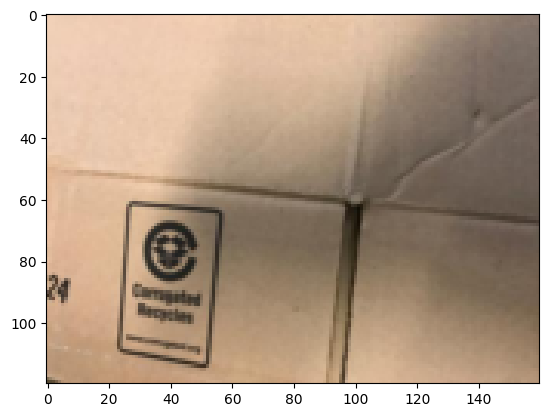

In [8]:
img, label = dataset[64]
show_sample(img, label)

### Split Data

In [10]:
random_seed = 42
torch.manual_seed(random_seed)

In [11]:
len(dataset)

2678

In [12]:
train_size = int(0.6 * len(dataset))
val_size = int(0.3 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_seed))

print(f"Train size: {len(train_ds)}")
print(f"Val size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")


Train size: 1606
Val size: 803
Test size: 269


In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

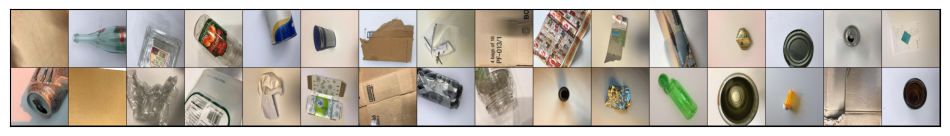

In [ ]:
show_batch(train_dl)

## Model

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [24]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        model_save_name = 'garbage_classifier[colour_cpu_256x256].pt'
        path = F"/content/drive/MyDrive/3B/ECE342/project/Model/{model_save_name}"
        torch.save(model.state_dict(), path)
    return history

In [25]:
model = to_device(ResNet(), device)

In [ ]:
evaluate(model, val_dl)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'val_loss': 1.9322623014450073, 'val_acc': 0.23152472078800201}

In [ ]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch 1: train_loss: 1.6459, val_loss: 1.4329, val_acc: 0.8007
Epoch 2: train_loss: 1.3374, val_loss: 1.3288, val_acc: 0.8710
Epoch 3: train_loss: 1.2369, val_loss: 1.2887, val_acc: 0.8876
Epoch 4: train_loss: 1.2060, val_loss: 1.2731, val_acc: 0.8997
Epoch 5: train_loss: 1.1868, val_loss: 1.2664, val_acc: 0.9023
Epoch 6: train_loss: 1.1850, val_loss: 1.2673, val_acc: 0.9031
Epoch 7: train_loss: 1.1795, val_loss: 1.2632, val_acc: 0.9033
Epoch 8: train_loss: 1.1852, val_loss: 1.2716, val_acc: 0.8900


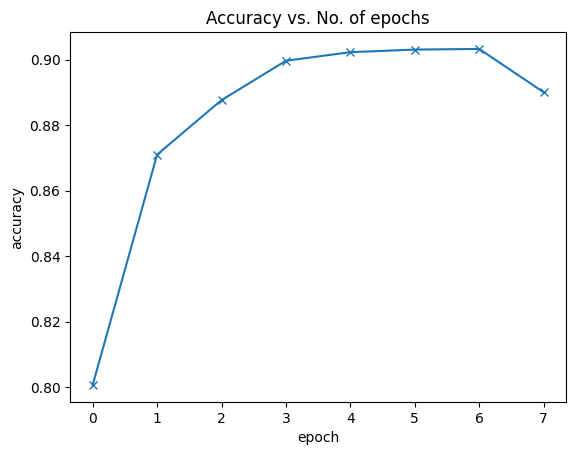

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

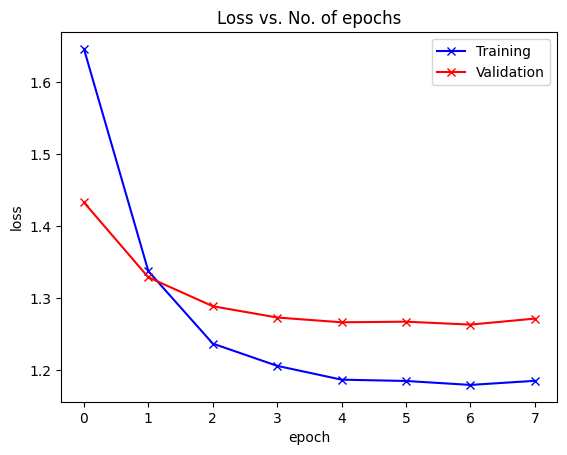

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

##Visualize Prediction

In [14]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1) #probs is how high
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
print(len(test_ds))

269


Label: cardboard , Predicted: Containers


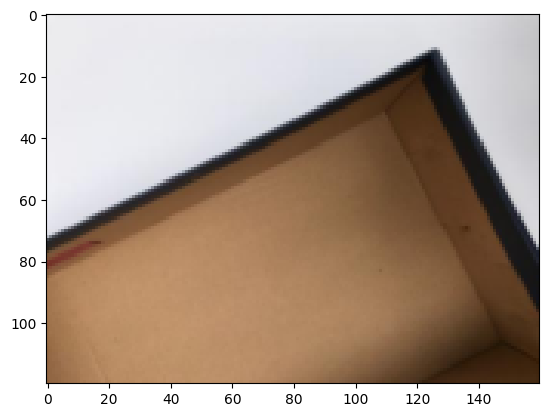

In [64]:
import random
i = random.randint(1, 268)

img, label = test_ds[i]
plt.imshow(img.permute(1, 2, 0))

prediction = predict_image(img, model)
if prediction == "cardboard":
  x = "Mixed Paper"
if prediction == "glass":
  x = "Containers"
if prediction == "metal":
  x = "Containers"
if prediction == "paper":
  x = "Mixed Paper"
if prediction == "plastic":
  x = "Containers"
if prediction == "trash":
  x = "Garbage"
if prediction == "cup":
  x = "Coffee Cups"

print('Label:', dataset.classes[label], ', Predicted:', x)